In [2]:
%reset
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
import numpy as np
import pandas as pd
from scipy import signal
import statistics as stats
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats
import scipy.sparse as sparse

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

def import_csv(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1]]
                data.append(columns)

    return data

def import_csv2(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10] ]
                data.append(columns)

    return data

def import_csv3(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10], row[11] ]
                data.append(columns)

    return data

def import_csv4(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4]]
                data.append(columns)

    return data

In [4]:
tcp_cca = (['TcpCubic-0.000100', 'TcpBbr-0.000100', 
            'TcpQtColFair_1.2minRTT-0.000100', 'TcpQtColFair_1.5minRTT-0.000100',
            'TcpCubic-0.001000', 'TcpBbr-0.001000', 
            'TcpQtColFair_1.2minRTT-0.001000', 'TcpQtColFair_1.5minRTT-0.001000',
            'TcpCubic-0.010000', 'TcpBbr-0.010000', 
            'TcpQtColFair_1.2minRTT-0.010000', 'TcpQtColFair_1.5minRTT-0.010000'
           ])
BDP = 172
buffer_size = 1727 
print(buffer_size, tcp_cca)

1727 ['TcpCubic-0.000100', 'TcpBbr-0.000100', 'TcpQtColFair_1.2minRTT-0.000100', 'TcpQtColFair_1.5minRTT-0.000100', 'TcpCubic-0.001000', 'TcpBbr-0.001000', 'TcpQtColFair_1.2minRTT-0.001000', 'TcpQtColFair_1.5minRTT-0.001000', 'TcpCubic-0.010000', 'TcpBbr-0.010000', 'TcpQtColFair_1.2minRTT-0.010000', 'TcpQtColFair_1.5minRTT-0.010000']


In [5]:
num_flows = 1
cwnd = {}
agg_cwnd = {}
inflight = {}
rtt = {}

for algorithm in tcp_cca:
    cwnd[algorithm] = {}
    agg_cwnd[algorithm] = {}
    inflight[algorithm] = {}
    rtt[algorithm] = {}


    agg_cwnd[algorithm] = {'time': list(), 'agg_cwnd': list(), 'agg_inflight': list(),
                'aveRtt': list(), 'agg_insThruput': list(), 'agg_aveThruput': list(), 
                'agg_insGoodput': list(), 'agg_aveGoodput': list(), 'agg_TxPkts': list(), 
                'agg_ReTxPkts': list(), 'fairness': list(), 'agg_cost': list()}
        
    for i in range(num_flows):
        cwnd[algorithm][i] = {'time': list(), 'cwnd': list(), 'inflight': list(),
                'rtt': list(), 'insThruput': list(), 'aveThruput': list(), 
                'insGoodput': list(), 'aveGoodput': list(), 'TxPkts': list(), 'ReTxPkts': list(), 
                'cost': list()}
                                       
        inflight[algorithm][i] = {'time': list(), 'inflight': list(), 'cwnd': list(), 
                                           'rtt': list(), 'cost': list()}
        rtt[algorithm][i] = {'time': list(), 'rtt': list()}

cwnd_files = []
agg_cwnd_files = []
inflight_files = []
rtt_files = []
                                               
for algorithm in tcp_cca:
    print(algorithm)
    cwnd_sim_files = []
    
    agg_cwnd_files.append("../results/qt_single_lossy/" + str(algorithm) + "/" + 
                str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                "p-" + "Agg" + "-cwnd.data")
    cwnd_flows_files = []
    
    for i in range(num_flows):
        cwnd_flows_files.append("../results/qt_single_lossy/" + str(algorithm) + "/" + 
                    str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                    algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                    "p-flow" + str(i) + "-cwnd.data")

        
        cwnd_files.append(cwnd_flows_files)


TcpCubic-0.000100
TcpBbr-0.000100
TcpQtColFair_1.2minRTT-0.000100
TcpQtColFair_1.5minRTT-0.000100
TcpCubic-0.001000
TcpBbr-0.001000
TcpQtColFair_1.2minRTT-0.001000
TcpQtColFair_1.5minRTT-0.001000
TcpCubic-0.010000
TcpBbr-0.010000
TcpQtColFair_1.2minRTT-0.010000
TcpQtColFair_1.5minRTT-0.010000


In [6]:
print(agg_cwnd_files[0])
print(agg_cwnd_files[1])
print(agg_cwnd_files[2])

../results/qt_single_lossy/TcpCubic-0.000100/1-flows/100Mbps-20ms/1727p-btlqueue/TcpCubic-0.000100-1-flows-100Mbps-20ms-1727p-Agg-cwnd.data
../results/qt_single_lossy/TcpBbr-0.000100/1-flows/100Mbps-20ms/1727p-btlqueue/TcpBbr-0.000100-1-flows-100Mbps-20ms-1727p-Agg-cwnd.data
../results/qt_single_lossy/TcpQtColFair_1.2minRTT-0.000100/1-flows/100Mbps-20ms/1727p-btlqueue/TcpQtColFair_1.2minRTT-0.000100-1-flows-100Mbps-20ms-1727p-Agg-cwnd.data


In [7]:

for algorithm  in tcp_cca:
    index_alg = tcp_cca.index(algorithm)
    print(algorithm,index_alg)

    agg_cwnd_data_in = import_csv3(agg_cwnd_files[index_alg])
    for row in agg_cwnd_data_in: 
        agg_cwnd[algorithm]['time'].append({row[0]})
        agg_cwnd[algorithm]['agg_cwnd'].append({row[1]})
        agg_cwnd[algorithm]['agg_inflight'].append({row[2]})
        agg_cwnd[algorithm]['aveRtt'].append({row[3]})
        agg_cwnd[algorithm]['agg_insThruput'].append({row[4]})
        agg_cwnd[algorithm]['agg_aveThruput'].append({row[5]})
        agg_cwnd[algorithm]['agg_insGoodput'].append({row[6]})
        agg_cwnd[algorithm]['agg_aveGoodput'].append({row[7]})
        agg_cwnd[algorithm]['agg_TxPkts'].append({row[8]})
        agg_cwnd[algorithm]['agg_ReTxPkts'].append({row[9]})
        agg_cwnd[algorithm]['fairness'].append({row[10]})
        agg_cwnd[algorithm]['agg_cost'].append({row[11]})

    for i in range(num_flows):
        cwnd_data_in = import_csv2(cwnd_files[index_alg][i])
        #inflight_data_in = import_csv4(inflight_files[index_alg][i])
        #rtt_data_in = import_csv(rtt_files[index_alg][i])

        for row in cwnd_data_in:
            cwnd[algorithm][i]['time'].append({row[0]})
            cwnd[algorithm][i]['cwnd'].append({row[1]})
            cwnd[algorithm][i]['inflight'].append({row[2]})
            cwnd[algorithm][i]['rtt'].append({row[3]})
            cwnd[algorithm][i]['insThruput'].append({row[4]})
            cwnd[algorithm][i]['aveThruput'].append({row[5]})
            cwnd[algorithm][i]['insGoodput'].append({row[6]})
            cwnd[algorithm][i]['aveGoodput'].append({row[7]})
            cwnd[algorithm][i]['TxPkts'].append({row[8]})
            cwnd[algorithm][i]['ReTxPkts'].append({row[9]})
            cwnd[algorithm][i]['cost'].append({row[10]})



TcpCubic-0.000100 0
TcpBbr-0.000100 1
TcpQtColFair_1.2minRTT-0.000100 2
TcpQtColFair_1.5minRTT-0.000100 3
TcpCubic-0.001000 4
TcpBbr-0.001000 5
TcpQtColFair_1.2minRTT-0.001000 6
TcpQtColFair_1.5minRTT-0.001000 7
TcpCubic-0.010000 8
TcpBbr-0.010000 9
TcpQtColFair_1.2minRTT-0.010000 10
TcpQtColFair_1.5minRTT-0.010000 11


In [8]:
cwnd_time = []
cwnd_value = []
inflight_value = []
rtt_value = []
insThruput_value = []
aveThruput_value = []
insGoodput_value = []
aveGoodput_value = []
cost_value = []

agg_cwnd_time = []
agg_cwnd_value = []
agg_inflight_value = []
agg_rtt_value = []
agg_insThruput_value = []
agg_aveThruput_value = []
agg_insGoodput_value = []
agg_aveGoodput_value = []
fairness_value = []
agg_cost_value = []

for algorithm in tcp_cca:
    print(algorithm)
    cwnd_time_ = []
    cwnd_value_ = []
    inflight_value_ = []
    rtt_value_ = []
    insThruput_value_ = []
    aveThruput_value_ = []
    insGoodput_value_ = []
    aveGoodput_value_ = []
    cost_value_ = []
    

    agg_cwnd_time.append(pd.DataFrame(agg_cwnd[algorithm]['time']))
    agg_cwnd_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cwnd']))
    agg_inflight_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_inflight']))
    agg_rtt_value.append(pd.DataFrame(agg_cwnd[algorithm]['aveRtt']))
    agg_insThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insThruput']))  
    agg_aveThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveThruput']))  
    agg_insGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insGoodput']))  
    agg_aveGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveGoodput'])) 
    fairness_value.append(pd.DataFrame(agg_cwnd[algorithm]['fairness'])) 
    agg_cost_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cost'])) 
    
    
    for i in range(num_flows):
        cwnd_time_.append(pd.DataFrame(cwnd[algorithm][i]['time']))
        cwnd_value_.append(pd.DataFrame(cwnd[algorithm][i]['cwnd']))
        cost_value_.append(pd.DataFrame(cwnd[algorithm][i]['cost']))
        inflight_value_.append(pd.DataFrame(cwnd[algorithm][i]['inflight']))
        rtt_value_.append(pd.DataFrame(cwnd[algorithm][i]['rtt']))
        insThruput_value_.append(pd.DataFrame(cwnd[algorithm][i]['insThruput']))  
        aveThruput_value_.append(pd.DataFrame(cwnd[algorithm][i]['aveThruput']))  
        insGoodput_value_.append(pd.DataFrame(cwnd[algorithm][i]['insGoodput']))  
        aveGoodput_value_.append(pd.DataFrame(cwnd[algorithm][i]['aveGoodput'])) 
        
    cwnd_time.append(cwnd_time_)
    cwnd_value.append(cwnd_value_)
    cost_value.append(cost_value_)
    inflight_value.append(inflight_value_)
    rtt_value.append(rtt_value_)
    insThruput_value.append(insThruput_value_)
    aveThruput_value.append(aveThruput_value_)
    insGoodput_value.append(insGoodput_value_)
    aveGoodput_value.append(aveGoodput_value_)


TcpCubic-0.000100
TcpBbr-0.000100
TcpQtColFair_1.2minRTT-0.000100
TcpQtColFair_1.5minRTT-0.000100
TcpCubic-0.001000
TcpBbr-0.001000
TcpQtColFair_1.2minRTT-0.001000
TcpQtColFair_1.5minRTT-0.001000
TcpCubic-0.010000
TcpBbr-0.010000
TcpQtColFair_1.2minRTT-0.010000
TcpQtColFair_1.5minRTT-0.010000


/tmp/ipykernel_44232/900452037.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


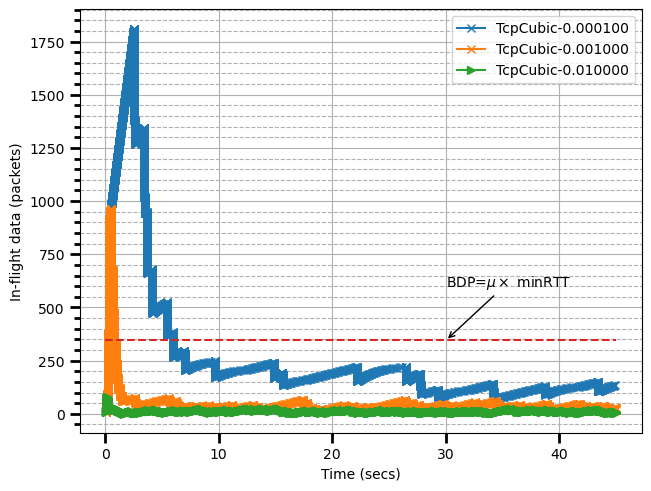

In [9]:
fig, ax1 = plt.subplots(constrained_layout=True)
t = [0,45]
bdp = [345,345]
ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), inflight_value[0][0].to_numpy(dtype=float)/1448,'x-',
        cwnd_time[4][0].to_numpy(dtype=float), inflight_value[4][0].to_numpy(dtype=float)/1448,'x-',
        cwnd_time[8][0].to_numpy(dtype=float), inflight_value[8][0].to_numpy(dtype=float)/1448,'>-',
        t, bdp, '--'
        )
arrowprops = dict(
    arrowstyle="->")
ax1.annotate(r'BDP=$\mu \times$ minRTT', xy=(30,345), xytext=(30,600), arrowprops=arrowprops)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'In-flight data (packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,1000)
#plt.xlim(0,50)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[4], tcp_cca[8]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_inflight_cubic.png', transparent=True)

/tmp/ipykernel_44232/3777181427.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


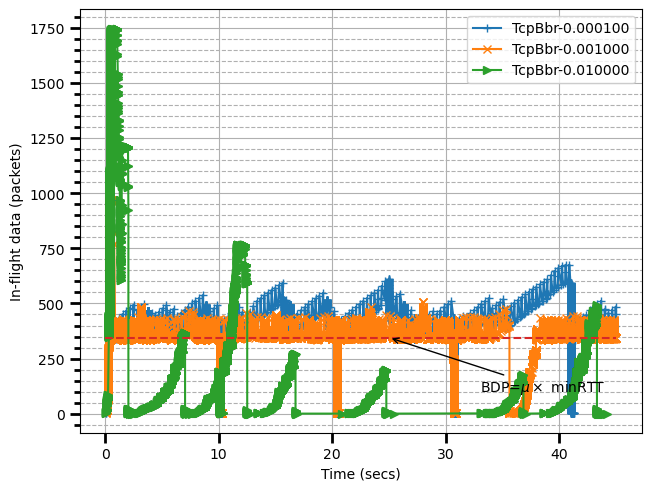

In [12]:
fig, ax1 = plt.subplots(constrained_layout=True)
t = [0,45]
bdp = [345,345]
ax1.plot(
        cwnd_time[1][0].to_numpy(dtype=float), inflight_value[1][0].to_numpy(dtype=float)/1448.0, '+-',
        cwnd_time[5][0].to_numpy(dtype=float), inflight_value[5][0].to_numpy(dtype=float)/1448.0, 'x-',
        cwnd_time[9][0].to_numpy(dtype=float), inflight_value[9][0].to_numpy(dtype=float)/1448,'>-',
        t, bdp, '--'
        )
arrowprops = dict(
    arrowstyle="->")
ax1.annotate(r'BDP=$\mu \times$ minRTT', xy=(25,345), xytext=(33,100), arrowprops=arrowprops)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'In-flight data (packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,1000)
#plt.xlim(0,20)
plt.grid(True)
plt.legend([
            tcp_cca[1], tcp_cca[5], tcp_cca[9]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_inflight_bbr.png', transparent=True)

/tmp/ipykernel_44232/568763877.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


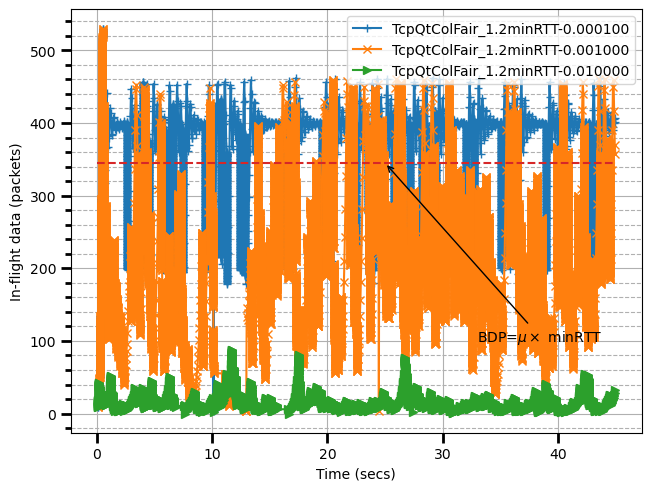

In [13]:
fig, ax1 = plt.subplots(constrained_layout=True)
t = [0,45]
bdp = [345,345]
ax1.plot(
        cwnd_time[2][0].to_numpy(dtype=float), inflight_value[2][0].to_numpy(dtype=float)/1448,'+-',
        cwnd_time[6][0].to_numpy(dtype=float), inflight_value[6][0].to_numpy(dtype=float)/1448,'x-',
        cwnd_time[10][0].to_numpy(dtype=float), inflight_value[10][0].to_numpy(dtype=float)/1448,'>-',
        t, bdp, '--'
        )
arrowprops = dict(
    arrowstyle="->")
ax1.annotate(r'BDP=$\mu \times$ minRTT', xy=(25,345), xytext=(33,100), arrowprops=arrowprops)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'In-flight data (packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,1000)
#plt.xlim(0,50)
plt.grid(True)
plt.legend([
            tcp_cca[2], tcp_cca[6], tcp_cca[10]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_inflight_qtcolfair1.2.png', transparent=True)

/tmp/ipykernel_44232/3917798421.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


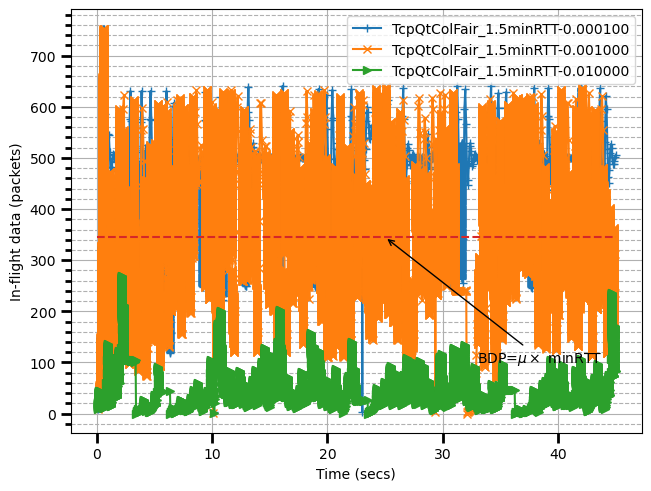

In [14]:
fig, ax1 = plt.subplots(constrained_layout=True)
t = [0,45]
bdp = [345,345]
ax1.plot(
        cwnd_time[3][0].to_numpy(dtype=float), inflight_value[3][0].to_numpy(dtype=float)/1448,'+-',
        cwnd_time[7][0].to_numpy(dtype=float), inflight_value[7][0].to_numpy(dtype=float)/1448,'x-',
        cwnd_time[11][0].to_numpy(dtype=float), inflight_value[11][0].to_numpy(dtype=float)/1448,'>-',
        t, bdp, '--'
        )
arrowprops = dict(
    arrowstyle="->")
ax1.annotate(r'BDP=$\mu \times$ minRTT', xy=(25,345), xytext=(33,100), arrowprops=arrowprops)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'In-flight data (packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,1000)
#plt.xlim(20,60)
plt.grid(True)
plt.legend([
            tcp_cca[3], tcp_cca[7], tcp_cca[11]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_inflight_qtcolfair1.5.png', transparent=True)

/tmp/ipykernel_44232/544434203.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


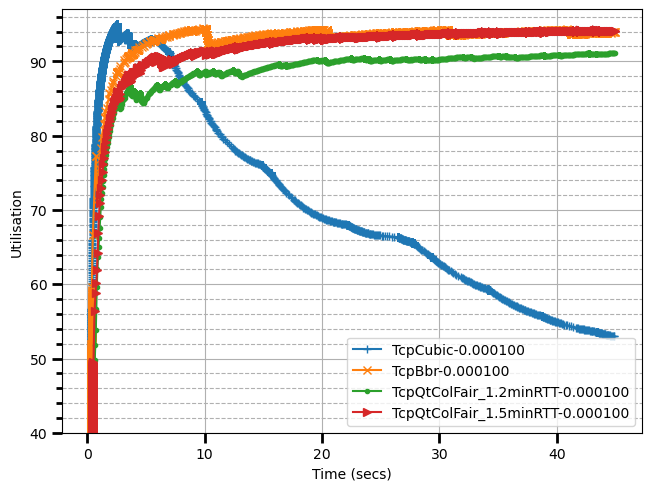

In [34]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), aveThruput_value[0][0].to_numpy(dtype=float), '+-',
        cwnd_time[1][0].to_numpy(dtype=float), aveThruput_value[1][0].to_numpy(dtype=float), 'x-',
        cwnd_time[2][0].to_numpy(dtype=float), aveThruput_value[2][0].to_numpy(dtype=float), '.-',
        cwnd_time[3][0].to_numpy(dtype=float), aveThruput_value[3][0].to_numpy(dtype=float),'>-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
ax1.set_ylabel(r'Thruput (Mbps)')
ax1.set_ylabel(r'Utilisation')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#ax2.set_ylim(65,97)
ax1.set_ylim(40,97)
#plt.xlim(0,15)
plt.grid(True)
ax1.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[2], tcp_cca[3]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_thruput_0.0001.png', transparent=True)

/tmp/ipykernel_44232/2706129897.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


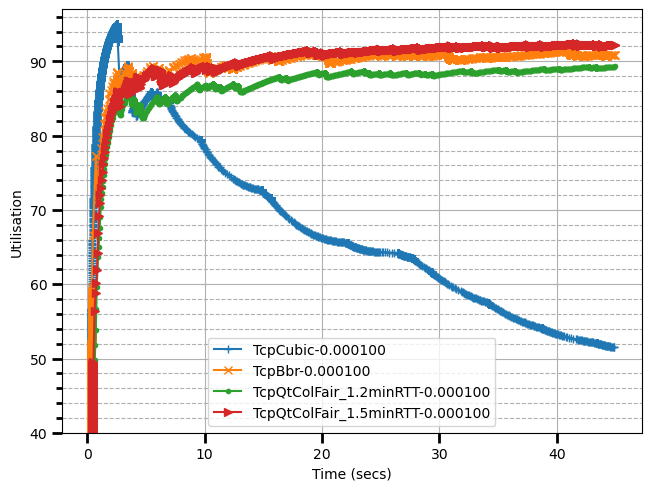

In [35]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), aveGoodput_value[0][0].to_numpy(dtype=float), '+-',
        cwnd_time[1][0].to_numpy(dtype=float), aveGoodput_value[1][0].to_numpy(dtype=float), 'x-',
        cwnd_time[2][0].to_numpy(dtype=float), aveGoodput_value[2][0].to_numpy(dtype=float), '.-',
        cwnd_time[3][0].to_numpy(dtype=float), aveGoodput_value[3][0].to_numpy(dtype=float),'>-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
ax1.set_ylabel(r'Goodput (Mbps)')
ax1.set_ylabel(r'Utilisation')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#ax2.set_ylim(65,97)
ax1.set_ylim(40,97)
#plt.xlim(0,15)
plt.grid(True)
ax1.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[2], tcp_cca[3]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_goodput_0.0001.png', transparent=True)

/tmp/ipykernel_44232/2411593609.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


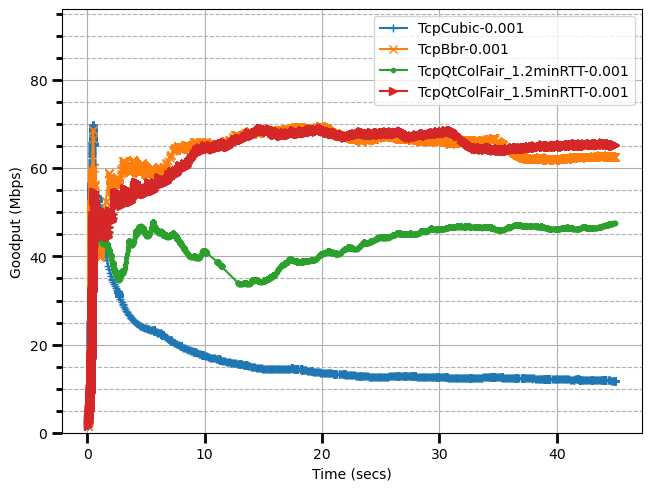

In [30]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[4][0].to_numpy(dtype=float), aveGoodput_value[4][0].to_numpy(dtype=float), '+-',
        cwnd_time[5][0].to_numpy(dtype=float), aveGoodput_value[5][0].to_numpy(dtype=float), 'x-',
        cwnd_time[6][0].to_numpy(dtype=float), aveGoodput_value[6][0].to_numpy(dtype=float), '.-',
        cwnd_time[7][0].to_numpy(dtype=float), aveGoodput_value[7][0].to_numpy(dtype=float),'>-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
ax1.set_ylabel(r'Goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#ax2.set_ylim(65,97)
ax1.set_ylim(0,96)
#plt.xlim(0,15)
plt.grid(True)
ax1.legend([
            tcp_cca[4].replace('000',''), tcp_cca[5].replace('000',''), 
            tcp_cca[6].replace('000',''), tcp_cca[7].replace('000','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_goodput_0.06.png', transparent=True)

/tmp/ipykernel_44232/3670026881.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


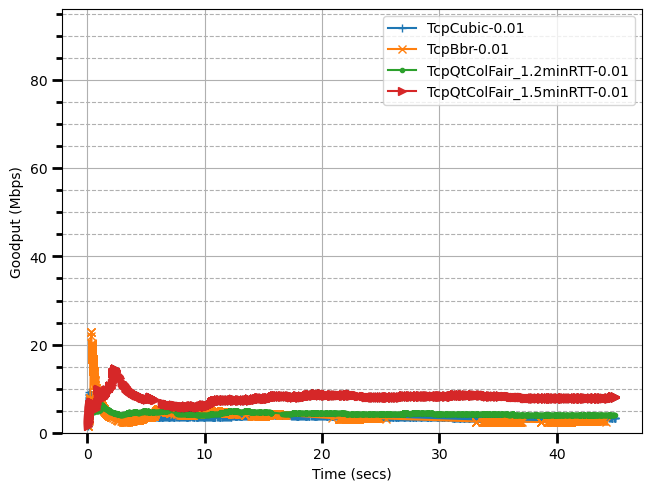

In [28]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[8][0].to_numpy(dtype=float), aveGoodput_value[8][0].to_numpy(dtype=float), '+-',
        cwnd_time[9][0].to_numpy(dtype=float), aveGoodput_value[9][0].to_numpy(dtype=float), 'x-',
        cwnd_time[10][0].to_numpy(dtype=float), aveGoodput_value[10][0].to_numpy(dtype=float), '.-',
        cwnd_time[11][0].to_numpy(dtype=float), aveGoodput_value[11][0].to_numpy(dtype=float),'>-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
ax1.set_ylabel(r'Goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
ax1.set_ylim(0,96)
##plt.xlim(0,15)
plt.grid(True)
ax1.legend([
            tcp_cca[8].replace('0000',''), tcp_cca[9].replace('0000',''), 
            tcp_cca[10].replace('0000',''), tcp_cca[11].replace('0000','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_goodput_0.01.png', transparent=True)

/tmp/ipykernel_44232/649374277.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


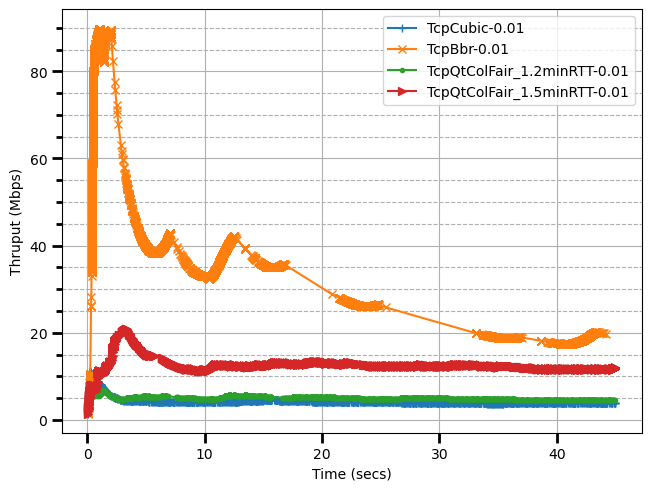

In [22]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[8][0].to_numpy(dtype=float), aveThruput_value[8][0].to_numpy(dtype=float), '+-',
        cwnd_time[9][0].to_numpy(dtype=float), aveThruput_value[9][0].to_numpy(dtype=float), 'x-',
        cwnd_time[10][0].to_numpy(dtype=float), aveThruput_value[10][0].to_numpy(dtype=float), '.-',
        cwnd_time[11][0].to_numpy(dtype=float), aveThruput_value[11][0].to_numpy(dtype=float),'>-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
ax1.set_ylabel(r'Thruput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#ax2.set_ylim(65,97)
#ax1.set_ylim(0.65,0.97)
#plt.xlim(0,15)
plt.grid(True)
ax1.legend([
            tcp_cca[8].replace('0000',''), tcp_cca[9].replace('0000',''), 
            tcp_cca[10].replace('0000',''), tcp_cca[11].replace('0000','')
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('single_lossy/single_lossy_Thruput_0.11.png', transparent=True)